# Insuline simulator

The goal of this project is to improve the quality of life for individuals with type 1 diabetes. We focus on simulating food and carbohydrate intake to automatically deliver the appropriate insulin dose when needed, ensuring that glucose levels are consistently kept within a healthy range.
### System Methodology

To train our RL agent safely and efficiently, we have constructed a digital simulation environment using the `simglucose` library, a validated simulator that models the complex dynamics of glucose in the human body. The key to our system is a "wrapper" class that adapts this simulation to the standardized interface of `gymnasium`, the industry standard for RL environments.

This environment defines the "playground" for our AI and is composed of the following elements:

1.  **Environment Construction**: Upon starting a simulation, the system configures a complete virtual scenario. A virtual patient is selected from a set of predefined profiles, each with its own physiological parameters. Next, the simulated devices are initialized: a Continuous Glucose Monitor (CGM), which acts as the agent's "eyes," and an insulin pump, which serves as its "hands." Finally, a meal scenario is introduced to simulate carbohydrate intake.

2.  **Interaction and Learning**: The training occurs in discrete 1-minute cycles. In each step:
    * The agent **observes** the current glucose level, $G(t)$.
    * Based on this observation, it decides on an **action**: the insulin dose to be administered.
    * The environment receives this action, the simulation advances by 1 minutes, and `simglucose` calculates the new glucose level, $G(t+1)$, accounting for both the injected insulin and the effect of meals.
    * The agent receives a **reward**: a positive score is awarded for maintaining glucose within the target range, while states of hypoglycemia and hyperglycemia are heavily penalized.

Through thousands of these "trial-and-error" cycles, the agent learns to associate specific glucose levels with optimal insulin doses, with the ultimate goal of maximizing its cumulative reward and, therefore, maintaining the virtual patient's glycemic stability. This project represents a step towards more intelligent, dynamic, and personalized diabetes control systems.

### Why simglucose?

This is the main engine of the simulation. It provides the mathematical models for:

* **T1DPatient:** Simulates the physiology of a patient with type 1 diabetes (how their body reacts to insulin, carbohydrates, etc.).
* **CGMSensor:** Simulates a Continuous Glucose Monitor (CGM), which measures the patient's glucose level.
* **InsulinPump:** Simulates an insulin pump, the device that administers insulin.


In [1]:
!pip install matplotlib numpy simglucose


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from simglucose.envs.simglucose_gym_env import T1DSimEnv
from simglucose.simulation.scenario import Scenario

To discretize glucose we define 4 levels for glucose and 3 levels for the velocity of glucose change.
Lower levels are for lower glucose, the velocity acts as a factor to be added in case of a positive change (more velocity=adding more).

In [3]:
def discretize_glucose(glucose, glucose_velocity, bins=[70, 120, 180]):
    # Bins: <70, 70-120, 120-180, >180
    if glucose < 70:
        glucose_level = 0
    elif glucose < 120:
        glucose_level = 1
    elif glucose < 180:
        glucose_level = 2
    else:
        glucose_level = 3

    if glucose_velocity < -5: # fast down
        velocity_level = 0
    elif glucose_velocity > 5: # fast up
        velocity_level = 2
    else:
        velocity_level = 1


    return glucose_level * 3 + velocity_level

In [4]:
action_space = np.arange(0, 2, 0.5) # e.g. 0, 0.5, ..., 2
n_actions = len(action_space)
n_states = 12 # 4 level of glucose * 3 levels of velocity

The reward function is a Gaussian centered in 115 mg/dL, with a standard deviation of 25 mg/dL. Since the most problematic case is hypoglycemia, we penalize it more heavily than hyperglycemia.

In [5]:
def reward_fn(glucose):
    mu = 115
    sigma = 25
    reward = np.exp(-0.5 * ((glucose - mu) / sigma) ** 2)
    if glucose < 70:
        reward -= 2000.0
    return reward

In [6]:
class TDControlAgent:
    def __init__(self, n_states, n_actions, gamma=0.99, lr=0.1, alg="qlearning"):
        self.gamma = gamma
        self.lr = lr
        self.n_states = n_states
        self.n_actions = n_actions
        self.Qvalues = np.zeros((n_states, n_actions))
        self.alg = alg # "sarsa" or "qlearning"

    def get_action_epsilon_greedy(self, s, eps):
        if np.random.rand() < eps:
            return np.random.randint(self.n_actions)
        else:
            best_value = np.max(self.Qvalues[s])
            best_actions = (self.Qvalues[s] == best_value)
            prob_actions = best_actions / np.sum(best_actions)
            return np.random.choice(self.n_actions, p=prob_actions)
        
    # Compute expected Q value under the epsilon-greedy policy at state new_s.
    # Each action has probability ε / n_actions, except the best one which gets (1 - ε) + ε / n_actions.
    # This reduces variance compared to SARSA by averaging over all possible next actions.   
    def epsilon_greedy_policy(self, s, eps):
        policy = np.ones(self.n_actions) * (eps / self.n_actions)
        best_action = np.argmax(self.Qvalues[s])
        policy[best_action] += (1.0 - eps)
        return policy
    
    def single_step_update(self, s, a, r, new_s, new_a=None, done=False, eps=None):
        if self.alg == "sarsa":
            if done:
                deltaQ = r - self.Qvalues[s, a]
            else:
                deltaQ = r + self.gamma * self.Qvalues[new_s, new_a] - self.Qvalues[s, a]
        elif self.alg == "qlearning":
            if done:
                deltaQ = r - self.Qvalues[s, a]
            else:
                deltaQ = r + self.gamma * np.max(self.Qvalues[new_s]) - self.Qvalues[s, a]
        elif self.alg == "expected_sarsa":
            if done:
                deltaQ = r - self.Qvalues[s, a]
            else:
                if eps is None:
                    raise ValueError("Expected Sarsa needs eps")
                policy = self.epsilon_greedy_policy(new_s, eps)
                expected_value = np.sum(policy * self.Qvalues[new_s])
                deltaQ = r + self.gamma * expected_value - self.Qvalues[s, a]
        else:
            raise ValueError("Unknown algorithm")
        self.Qvalues[s, a] += self.lr * deltaQ

## Q-learning TD(0)

Here, and also the next time we will initialize an environment, we are considering a specific patient profile (`"adolescent#001"`) with randomized meal scenarios. The agent will learn to manage insulin delivery based on the glucose levels observed from the CGM sensor.

In [7]:
env = T1DSimEnv()
agent = TDControlAgent(n_states=n_states, n_actions=n_actions, gamma=0.99, lr=0.05, alg="qlearning")
epsilon = 0.1
num_episodes = 5000
performance = np.zeros(num_episodes)

This cell is for the training, it takes a long time so if you want you can skip it and use the pre-trained model 2 cells below.

In [ ]:
for episode in range(num_episodes):
    obs = env.reset()
    if hasattr(obs, "CGM"):
        glucose = obs.CGM
    else:
        glucose = obs[0] if isinstance(obs, (np.ndarray, list)) else obs

    # Initialize velocity and state
    glucose_velocity = 0
    s = discretize_glucose(glucose, glucose_velocity)
    a = agent.get_action_epsilon_greedy(s, epsilon)

    done = False
    while not done:
        # Agent takes an action
        insulin_dose = action_space[a]
        step_result = env.step(insulin_dose)
        if isinstance(step_result, tuple) and len(step_result) == 4:
            next_obs, _, done, info = step_result
        else:
            next_obs, done = step_result, False

        # Extract next glucose reading
        if hasattr(next_obs, "CGM"):
            next_glucose = next_obs.CGM
        else:
            next_glucose = next_obs[0] if isinstance(next_obs, (np.ndarray, list)) else next_obs

        # Calculate velocity
        glucose_velocity = next_glucose - glucose

        # Get reward and new state
        r = reward_fn(next_glucose)
        performance[episode] += r
        new_s = discretize_glucose(next_glucose, glucose_velocity)

        # --- COMBINED UPDATE AND DECISION LOGIC ---

        # 1. Agent updates its knowledge
        agent.single_step_update(s, a, r, new_s, done=done)

        # 2. Decide the next action with the FORCED WAIT rule
        if action_space[a] > 0:
            a_next = 0  # If we just injected, the next action is 0
        else:
            a_next = agent.get_action_epsilon_greedy(new_s, epsilon)

        # 3. Final safety rule
        if next_glucose < 120: # If glucose is < 120 mg/dL
            a_next = 0

        # 4. Update variables for the next loop iteration
        glucose = next_glucose
        s = new_s
        a = a_next

    # Print progress every 500 episodes
    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes} completed.")

print("\nAdvanced training complete.")

In [ ]:
np.save('q_table.npy', agent.Qvalues)
print("Model (Table Q) saved correctly in 'q_table.npy'!")

To see how the model performs, we have a look at the insuline level during more or less half a day.

Scenario of meals generated:
{'time': [np.float64(404.0), np.float64(675.0), np.float64(1145.0), np.float64(1295.0)], 'amount': [53, 61, 73, 17]}


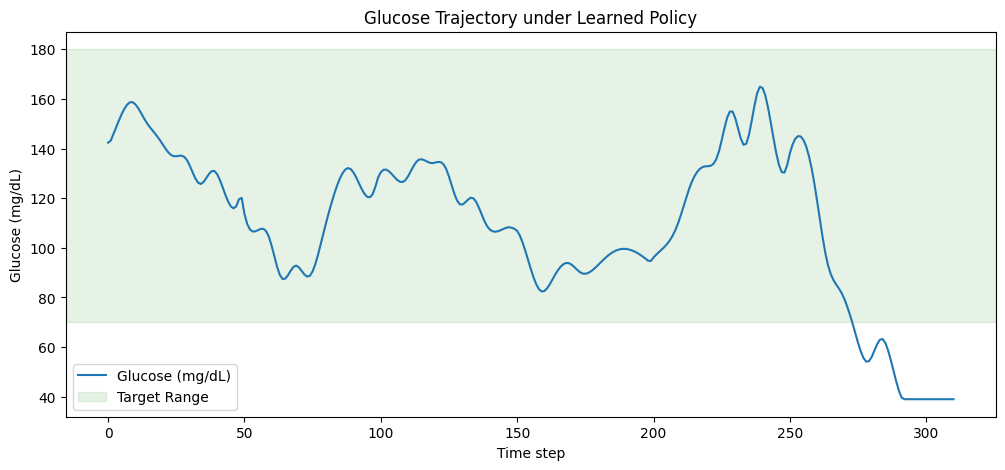

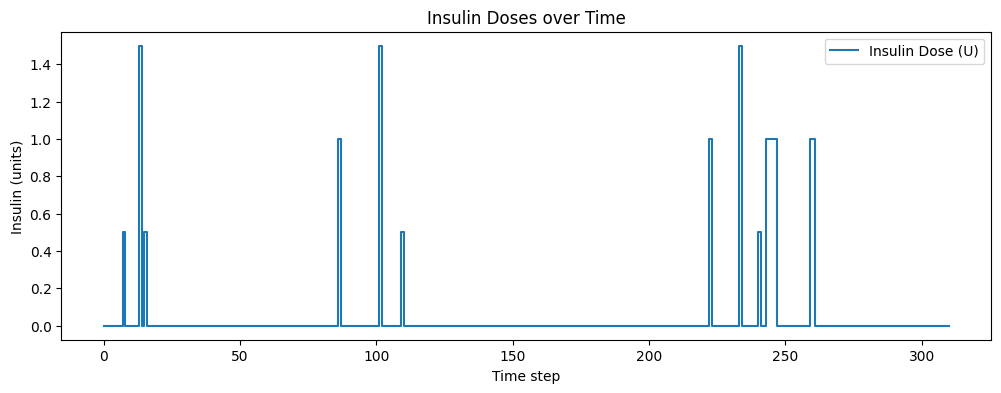

In [8]:
import matplotlib.pyplot as plt

agent_test = TDControlAgent(n_states=n_states, n_actions=n_actions)
agent_test.Qvalues = np.load('q_table.npy')
# Set epsilon=0 for greedy policy (pure exploitation)
epsilon_eval = 0.1

# Start a new episode
obs = env.reset()

# # Access the scenario generator from the underlying environment
scenario_generator = env.env.scenario

print("Scenario of meals generated:")

# Access the 'meal' key from the scenario dictionary
print(scenario_generator.scenario['meal'])
if isinstance(obs, tuple):
    obs = obs[0]
if hasattr(obs, "CGM"):
    glucose = obs.CGM
elif isinstance(obs, dict) and 'CGM' in obs:
    glucose = obs['CGM']
elif isinstance(obs, (np.ndarray, list)):
    glucose = obs[0]
elif isinstance(obs, (float, int)):
    glucose = obs
else:
    raise ValueError(f"Unknown observation format: {type(obs)}")

glucose_velocity = 0
s = discretize_glucose(glucose, glucose_velocity)
a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
done = False

# Lists to record data
G_t = [glucose]
I_t = [action_space[a]]
rewards = []
times = [0]
t = 0

while not done and t < 500:
    insulin_dose = action_space[a]
    step_result = env.step(insulin_dose)
    if isinstance(step_result, tuple) and len(step_result) == 4:
        next_obs, _, done, info = step_result
    else:
        next_obs = step_result
        done = False

    if hasattr(next_obs, "CGM"):
        next_glucose = next_obs.CGM
    elif isinstance(next_obs, dict) and 'CGM' in next_obs:
        next_glucose = next_obs['CGM']
    elif isinstance(next_obs, (np.ndarray, list)):
        next_glucose = next_obs[0]
    elif isinstance(next_obs, (float, int)):
        next_glucose = next_obs
    else:
        raise ValueError(f"Unknown observation format: {type(next_obs)}")

    glucose_velocity = next_glucose - glucose
    new_s = discretize_glucose(next_glucose, glucose_velocity)
    r = reward_fn(next_glucose)
    rewards.append(r)
    G_t.append(next_glucose)
    I_t.append(insulin_dose)
    t += 1
    times.append(t)

    glucose = next_glucose
    s = new_s
    a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
    if next_glucose < 120:  # Safety rule
        a = 0  # Ensure no insulin is given if glucose is below 120

# Plot glucose over time
plt.figure(figsize=(12,5))
plt.plot(times, G_t, label='Glucose (mg/dL)')
plt.axhspan(70, 180, color='green', alpha=0.1, label='Target Range')
plt.xlabel('Time step')
plt.ylabel('Glucose (mg/dL)')
plt.title('Glucose Trajectory under Learned Policy')
plt.legend()
plt.show()

# Optional: Plot insulin doses
plt.figure(figsize=(12,4))
plt.step(times, I_t, label='Insulin Dose (U)', where='post')
plt.xlabel('Time step')
plt.ylabel('Insulin (units)')
plt.title('Insulin Doses over Time')
plt.legend()
plt.show()

## Q-learning TD(1)

This is the case in which we wait for the end of the episode to update.

In [9]:
env = T1DSimEnv()
agent = TDControlAgent(n_states=n_states, n_actions=n_actions, gamma=0.99, lr=0.05, alg="qlearning")
epsilon = 0.1
num_episodes = 5000
performance = np.zeros(num_episodes)

In [ ]:
for episode in range(num_episodes):
    obs = env.reset()
    if hasattr(obs, "CGM"):
        glucose = obs.CGM
    else:
        glucose = obs[0] if isinstance(obs, (np.ndarray, list)) else obs

    glucose_velocity = 0
    s = discretize_glucose(glucose, glucose_velocity)
    a = agent.get_action_epsilon_greedy(s, epsilon)
    done = False
    trajectory = []

    # Get the episode
    while not done:
        insulin_dose = action_space[a]
        step_result = env.step(insulin_dose)
        if isinstance(step_result, tuple) and len(step_result) == 4:
            next_obs, _, done, info = step_result
        else:
            next_obs, done = step_result, False

        if hasattr(next_obs, "CGM"):
            next_glucose = next_obs.CGM
        else:
            next_glucose = next_obs[0] if isinstance(next_obs, (np.ndarray, list)) else next_obs

        glucose_velocity = next_glucose - glucose
        r = reward_fn(next_glucose)
        performance[episode] += r
        new_s = discretize_glucose(next_glucose, glucose_velocity)

        # Action
        if action_space[a] > 0:
            a_next = 0
        else:
            a_next = agent.get_action_epsilon_greedy(new_s, epsilon)
        if next_glucose < 120:
            a_next = 0

        # Save transition (s, a, r)
        trajectory.append((s, a, r))

        glucose = next_glucose
        s = new_s
        a = a_next

    # Montecarlo update
    G = 0
    gamma = agent.gamma
    # For each transition starting from the end
    for t in reversed(range(len(trajectory))):
        s, a, r = trajectory[t]
        G = r + gamma * G  # Cumulative return
        agent.Qvalues[s, a] += agent.lr * (G - agent.Qvalues[s, a])

    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes} completed.")

print("\nTraining Monte Carlo (TD(1)) completed.")

In [ ]:
np.save('q1_table.npy', agent.Qvalues)
print("Model (Table Q) saved correctly in 'q1_table.npy'!")

Scenario of meals generated:
{'time': [np.float64(395.0), np.float64(647.0), np.float64(895.0), np.float64(1027.0)], 'amount': [35, 64, 17, 82]}


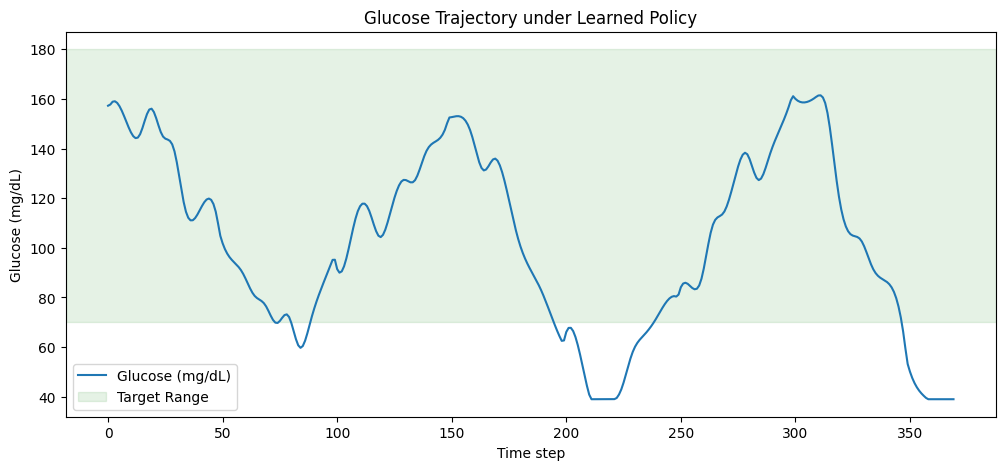

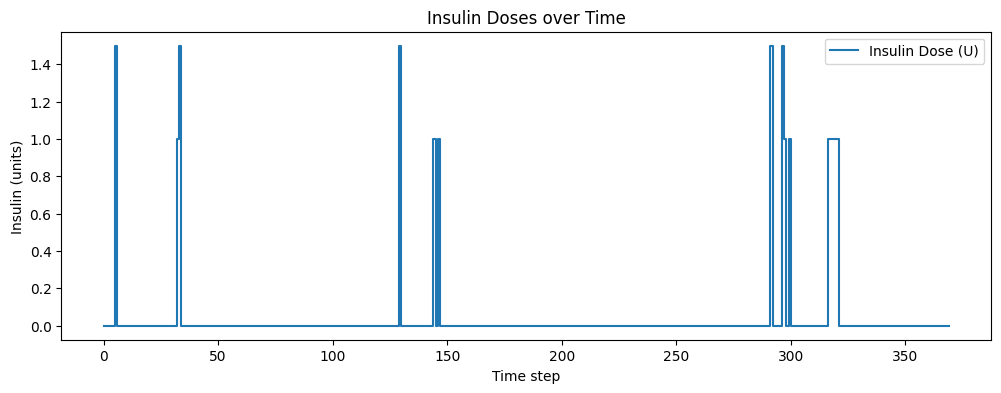

In [10]:
agent_test = TDControlAgent(n_states=n_states, n_actions=n_actions)
agent_test.Qvalues = np.load('q1_table.npy')
# Set epsilon=0 for greedy policy (pure exploitation)
epsilon_eval = 0.1

# Start a new episode
obs = env.reset()

# # Access the scenario generator from the underlying environment
scenario_generator = env.env.scenario

print("Scenario of meals generated:")

# Access the 'meal' key from the scenario dictionary
print(scenario_generator.scenario['meal'])
if isinstance(obs, tuple):
    obs = obs[0]
if hasattr(obs, "CGM"):
    glucose = obs.CGM
elif isinstance(obs, dict) and 'CGM' in obs:
    glucose = obs['CGM']
elif isinstance(obs, (np.ndarray, list)):
    glucose = obs[0]
elif isinstance(obs, (float, int)):
    glucose = obs
else:
    raise ValueError(f"Unknown observation format: {type(obs)}")

glucose_velocity = 0
s = discretize_glucose(glucose, glucose_velocity)
a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
done = False

# Lists to record data
G_t = [glucose]
I_t = [action_space[a]]
rewards = []
times = [0]
t = 0

while not done and t < 500:
    insulin_dose = action_space[a]
    step_result = env.step(insulin_dose)
    if isinstance(step_result, tuple) and len(step_result) == 4:
        next_obs, _, done, info = step_result
    else:
        next_obs = step_result
        done = False

    if hasattr(next_obs, "CGM"):
        next_glucose = next_obs.CGM
    elif isinstance(next_obs, dict) and 'CGM' in next_obs:
        next_glucose = next_obs['CGM']
    elif isinstance(next_obs, (np.ndarray, list)):
        next_glucose = next_obs[0]
    elif isinstance(next_obs, (float, int)):
        next_glucose = next_obs
    else:
        raise ValueError(f"Unknown observation format: {type(next_obs)}")

    glucose_velocity = next_glucose - glucose
    new_s = discretize_glucose(next_glucose, glucose_velocity)
    r = reward_fn(next_glucose)
    rewards.append(r)
    G_t.append(next_glucose)
    I_t.append(insulin_dose)
    t += 1
    times.append(t)

    glucose = next_glucose
    s = new_s
    a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
    if next_glucose < 120:  # Safety rule
        a = 0  # Ensure no insulin is given if glucose is below 120

# Plot glucose over time
plt.figure(figsize=(12,5))
plt.plot(times, G_t, label='Glucose (mg/dL)')
plt.axhspan(70, 180, color='green', alpha=0.1, label='Target Range')
plt.xlabel('Time step')
plt.ylabel('Glucose (mg/dL)')
plt.title('Glucose Trajectory under Learned Policy')
plt.legend()
plt.show()

# Optional: Plot insulin doses
plt.figure(figsize=(12,4))
plt.step(times, I_t, label='Insulin Dose (U)', where='post')
plt.xlabel('Time step')
plt.ylabel('Insulin (units)')
plt.title('Insulin Doses over Time')
plt.legend()
plt.show()

## SARSA

In [11]:
env = T1DSimEnv()
agent = TDControlAgent(n_states=n_states, n_actions=n_actions, gamma=0.99, lr=0.05, alg="sarsa")
epsilon = 0.1
num_episodes = 5000
performance = np.zeros(num_episodes)

In [ ]:
for episode in range(num_episodes):
    obs = env.reset()
    if hasattr(obs, "CGM"):
        glucose = obs.CGM
    else:
        glucose = obs[0] if isinstance(obs, (np.ndarray, list)) else obs

    glucose_velocity = 0
    s = discretize_glucose(glucose, glucose_velocity)
    a = agent.get_action_epsilon_greedy(s, epsilon)
    done = False

    while not done:
        insulin_dose = action_space[a]
        step_result = env.step(insulin_dose)
        if isinstance(step_result, tuple) and len(step_result) == 4:
            next_obs, _, done, info = step_result
        else:
            next_obs, done = step_result, False

        if hasattr(next_obs, "CGM"):
            next_glucose = next_obs.CGM
        else:
            next_glucose = next_obs[0] if isinstance(next_obs, (np.ndarray, list)) else next_obs

        glucose_velocity = next_glucose - glucose
        r = reward_fn(next_glucose)
        performance[episode] += r
        new_s = discretize_glucose(next_glucose, glucose_velocity)

        # SARSA: choose next action using epsilon-greedy policy
        if action_space[a] > 0:
            a_next = 0  # Enforce forced wait after insulin
        else:
            a_next = agent.get_action_epsilon_greedy(new_s, epsilon)
        if next_glucose < 120:
            a_next = 0  # Safety

        # SARSA update: need both a and a_next
        agent.single_step_update(s, a, r, new_s, new_a=a_next, done=done)

        # Prepare for next step
        glucose = next_glucose
        s = new_s
        a = a_next

    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes} completed.")

print("\nSARSA training complete.")

In [ ]:
np.save('s_table.npy', agent.Qvalues)
print("Model (Table Q) saved correctly in 's_table.npy'!")

Scenario of meals generated:
{'time': [np.float64(417.0), np.float64(783.0), np.float64(847.0), np.float64(1051.0)], 'amount': [38, 85, 3, 87]}


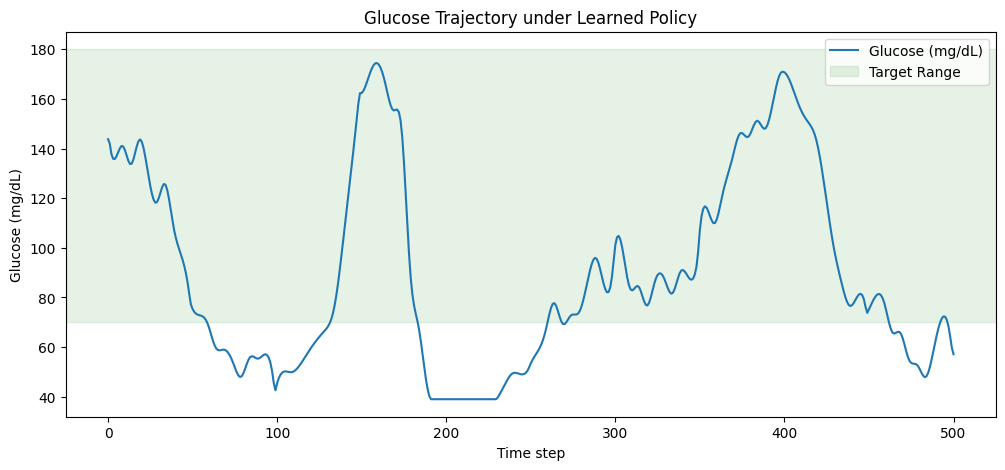

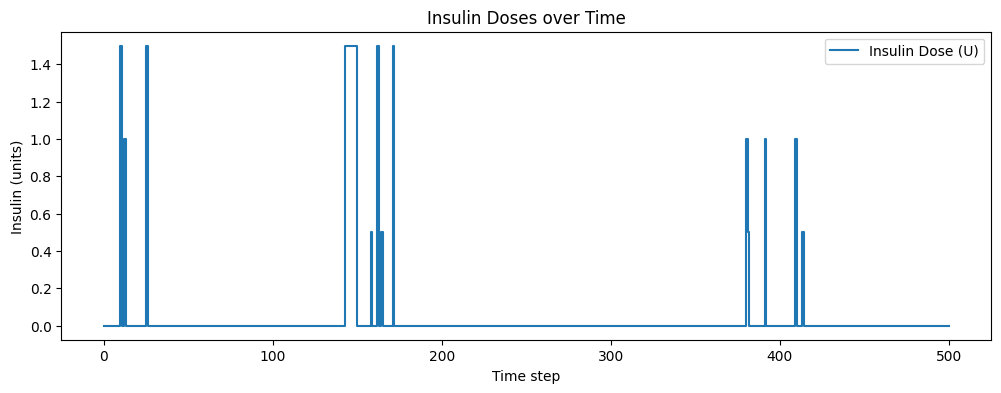

In [12]:
agent_test = TDControlAgent(n_states=n_states, n_actions=n_actions)
agent_test.Qvalues = np.load('s_table.npy')
# Set epsilon=0 for greedy policy (pure exploitation)
epsilon_eval = 0.1

# Start a new episode
obs = env.reset()

# # Access the scenario generator from the underlying environment
scenario_generator = env.env.scenario

print("Scenario of meals generated:")

# Access the 'meal' key from the scenario dictionary
print(scenario_generator.scenario['meal'])
if isinstance(obs, tuple):
    obs = obs[0]
if hasattr(obs, "CGM"):
    glucose = obs.CGM
elif isinstance(obs, dict) and 'CGM' in obs:
    glucose = obs['CGM']
elif isinstance(obs, (np.ndarray, list)):
    glucose = obs[0]
elif isinstance(obs, (float, int)):
    glucose = obs
else:
    raise ValueError(f"Unknown observation format: {type(obs)}")

glucose_velocity = 0
s = discretize_glucose(glucose, glucose_velocity)
a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
done = False

# Lists to record data
G_t = [glucose]
I_t = [action_space[a]]
rewards = []
times = [0]
t = 0

while not done and t < 500:
    insulin_dose = action_space[a]
    step_result = env.step(insulin_dose)
    if isinstance(step_result, tuple) and len(step_result) == 4:
        next_obs, _, done, info = step_result
    else:
        next_obs = step_result
        done = False

    if hasattr(next_obs, "CGM"):
        next_glucose = next_obs.CGM
    elif isinstance(next_obs, dict) and 'CGM' in next_obs:
        next_glucose = next_obs['CGM']
    elif isinstance(next_obs, (np.ndarray, list)):
        next_glucose = next_obs[0]
    elif isinstance(next_obs, (float, int)):
        next_glucose = next_obs
    else:
        raise ValueError(f"Unknown observation format: {type(next_obs)}")

    glucose_velocity = next_glucose - glucose
    new_s = discretize_glucose(next_glucose, glucose_velocity)
    r = reward_fn(next_glucose)
    rewards.append(r)
    G_t.append(next_glucose)
    I_t.append(insulin_dose)
    t += 1
    times.append(t)

    glucose = next_glucose
    s = new_s
    a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
    if next_glucose < 120:  # Safety rule
        a = 0  # Ensure no insulin is given if glucose is below 120

# Plot glucose over time
plt.figure(figsize=(12,5))
plt.plot(times, G_t, label='Glucose (mg/dL)')
plt.axhspan(70, 180, color='green', alpha=0.1, label='Target Range')
plt.xlabel('Time step')
plt.ylabel('Glucose (mg/dL)')
plt.title('Glucose Trajectory under Learned Policy')
plt.legend()
plt.show()

# Optional: Plot insulin doses
plt.figure(figsize=(12,4))
plt.step(times, I_t, label='Insulin Dose (U)', where='post')
plt.xlabel('Time step')
plt.ylabel('Insulin (units)')
plt.title('Insulin Doses over Time')
plt.legend()
plt.show()

## Expected SARSA

In [13]:
env = T1DSimEnv()
agent = TDControlAgent(n_states=n_states, n_actions=n_actions, gamma=0.99, lr=0.05, alg="expected_sarsa")
epsilon = 0.1
num_episodes = 5000
performance = np.zeros(num_episodes)

In [ ]:
for episode in range(num_episodes):
    obs = env.reset()
    if hasattr(obs, "CGM"):
        glucose = obs.CGM
    else:
        glucose = obs[0] if isinstance(obs, (np.ndarray, list)) else obs

    glucose_velocity = 0
    s = discretize_glucose(glucose, glucose_velocity)
    a = agent.get_action_epsilon_greedy(s, epsilon)
    done = False

    while not done:
        insulin_dose = action_space[a]
        step_result = env.step(insulin_dose)
        if isinstance(step_result, tuple) and len(step_result) == 4:
            next_obs, _, done, info = step_result
        else:
            next_obs, done = step_result, False

        if hasattr(next_obs, "CGM"):
            next_glucose = next_obs.CGM
        else:
            next_glucose = next_obs[0] if isinstance(next_obs, (np.ndarray, list)) else next_obs

        glucose_velocity = next_glucose - glucose
        r = reward_fn(next_glucose)
        performance[episode] += r
        new_s = discretize_glucose(next_glucose, glucose_velocity)

        # Decide next action (for forced waiting and safety)
        if action_space[a] > 0:
            a_next = 0
        else:
            a_next = agent.get_action_epsilon_greedy(new_s, epsilon)
        if next_glucose < 120:
            a_next = 0

        # Update with expected sarsa
        agent.single_step_update(s, a, r, new_s, new_a=a_next, done=done, eps=epsilon)

        glucose = next_glucose
        s = new_s
        a = a_next

    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes} completed.")

print("\nTraining Expected Sarsa completed.")

In [ ]:
np.save('e_table.npy', agent.Qvalues)
print("Model (Table Q) saved correctly in 'e_table.npy'!")

Scenario of meals generated:
{'time': [np.float64(396.0), np.float64(692.0), np.float64(900.0), np.float64(1119.0), np.float64(1254.0)], 'amount': [55, 54, 9, 79, 17]}


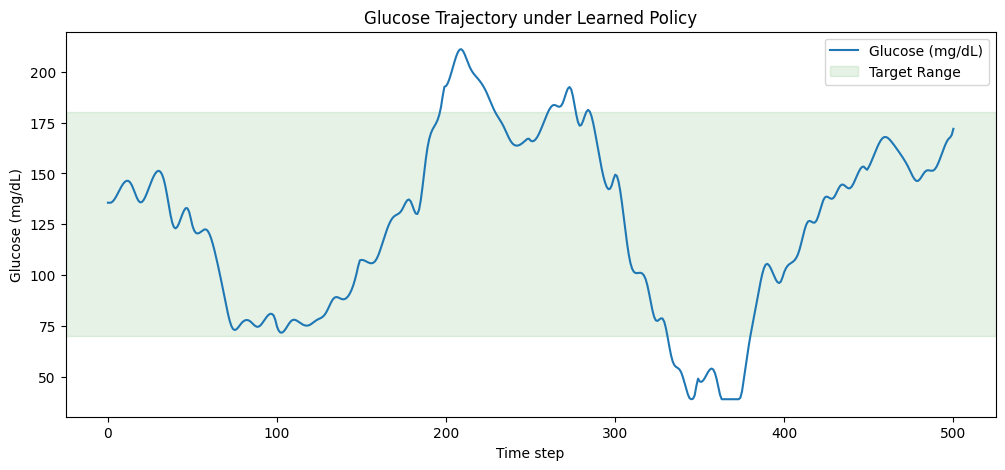

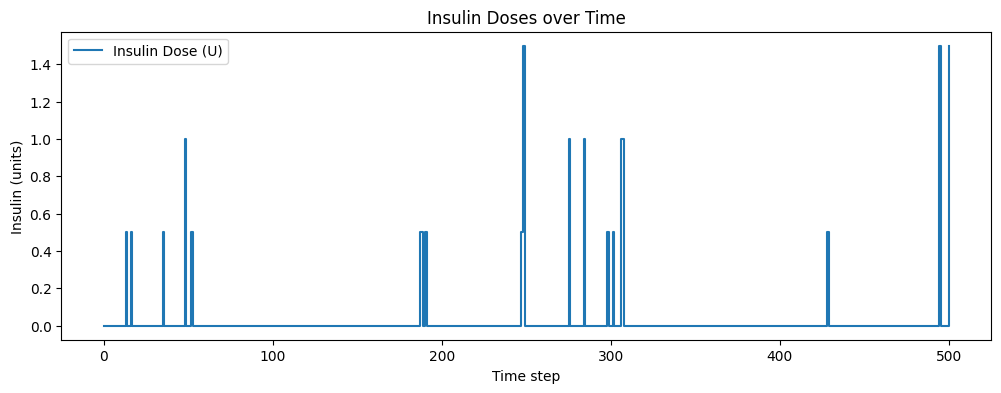

In [14]:
agent_test = TDControlAgent(n_states=n_states, n_actions=n_actions)
agent_test.Qvalues = np.load('e_table.npy')
# Set epsilon=0 for greedy policy (pure exploitation)
epsilon_eval = 0.1

# Start a new episode
obs = env.reset()

# # Access the scenario generator from the underlying environment
scenario_generator = env.env.scenario

print("Scenario of meals generated:")

# Access the 'meal' key from the scenario dictionary
print(scenario_generator.scenario['meal'])
if isinstance(obs, tuple):
    obs = obs[0]
if hasattr(obs, "CGM"):
    glucose = obs.CGM
elif isinstance(obs, dict) and 'CGM' in obs:
    glucose = obs['CGM']
elif isinstance(obs, (np.ndarray, list)):
    glucose = obs[0]
elif isinstance(obs, (float, int)):
    glucose = obs
else:
    raise ValueError(f"Unknown observation format: {type(obs)}")

glucose_velocity = 0
s = discretize_glucose(glucose, glucose_velocity)
a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
done = False

# Lists to record data
G_t = [glucose]
I_t = [action_space[a]]
rewards = []
times = [0]
t = 0

while not done and t < 500:
    insulin_dose = action_space[a]
    step_result = env.step(insulin_dose)
    if isinstance(step_result, tuple) and len(step_result) == 4:
        next_obs, _, done, info = step_result
    else:
        next_obs = step_result
        done = False

    if hasattr(next_obs, "CGM"):
        next_glucose = next_obs.CGM
    elif isinstance(next_obs, dict) and 'CGM' in next_obs:
        next_glucose = next_obs['CGM']
    elif isinstance(next_obs, (np.ndarray, list)):
        next_glucose = next_obs[0]
    elif isinstance(next_obs, (float, int)):
        next_glucose = next_obs
    else:
        raise ValueError(f"Unknown observation format: {type(next_obs)}")

    glucose_velocity = next_glucose - glucose
    new_s = discretize_glucose(next_glucose, glucose_velocity)
    r = reward_fn(next_glucose)
    rewards.append(r)
    G_t.append(next_glucose)
    I_t.append(insulin_dose)
    t += 1
    times.append(t)

    glucose = next_glucose
    s = new_s
    a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
    if next_glucose < 120:  # Safety rule
        a = 0  # Ensure no insulin is given if glucose is below 120

# Plot glucose over time
plt.figure(figsize=(12,5))
plt.plot(times, G_t, label='Glucose (mg/dL)')
plt.axhspan(70, 180, color='green', alpha=0.1, label='Target Range')
plt.xlabel('Time step')
plt.ylabel('Glucose (mg/dL)')
plt.title('Glucose Trajectory under Learned Policy')
plt.legend()
plt.show()

# Optional: Plot insulin doses
plt.figure(figsize=(12,4))
plt.step(times, I_t, label='Insulin Dose (U)', where='post')
plt.xlabel('Time step')
plt.ylabel('Insulin (units)')
plt.title('Insulin Doses over Time')
plt.legend()
plt.show()

## Tabular Reinforce

In [15]:
class REINFORCE:
    def __init__(self, n_states, n_actions, gamma=0.99, lr=0.01):
        self.gamma = gamma
        self.lr = lr
        self.n_states = n_states
        self.n_actions = n_actions
        self.Theta = np.zeros((n_states, n_actions))  # policy parameters

    def get_policy(self, s):
        logits = self.Theta[s] - np.max(self.Theta[s])
        probs = np.exp(logits) / np.sum(np.exp(logits))
        return probs

    def get_action(self, s):
        probs = self.get_policy(s)
        return np.random.choice(self.n_actions, p=probs)

    def update(self, states, actions, rewards):
        # Compute discounted returns
        G = np.zeros_like(rewards, dtype=np.float32)
        running_add = 0
        for t in reversed(range(len(rewards))):
            running_add = rewards[t] + self.gamma * running_add
            G[t] = running_add
        # Policy gradient update
        for s, a, g in zip(states, actions, G):
            probs = self.get_policy(s)
            for aa in range(self.n_actions):
                grad = (1 if aa == a else 0) - probs[aa]
                self.Theta[s, aa] += self.lr * g * grad

In [16]:
env = T1DSimEnv()
agent = REINFORCE(n_states=n_states, n_actions=n_actions, gamma=0.99, lr=0.01)
num_episodes = 5000
performance = np.zeros(num_episodes)
epsilon = 0.0  # Policy is always stochastic because of softmax, no need for epsilon-greedy

In [ ]:
for episode in range(num_episodes):
    obs = env.reset()
    if hasattr(obs, "CGM"):
        glucose = obs.CGM
    else:
        glucose = obs[0] if isinstance(obs, (np.ndarray, list)) else obs
    glucose_velocity = 0
    s = discretize_glucose(glucose, glucose_velocity)
    
    # Collect trajectory
    traj_states = []
    traj_actions = []
    traj_rewards = []
    done = False
    while not done:
        a = agent.get_action(s)
        insulin_dose = action_space[a]
        step_result = env.step(insulin_dose)
        if isinstance(step_result, tuple) and len(step_result) == 4:
            next_obs, _, done, info = step_result
        else:
            next_obs, done = step_result, False

        if hasattr(next_obs, "CGM"):
            next_glucose = next_obs.CGM
        else:
            next_glucose = next_obs[0] if isinstance(next_obs, (np.ndarray, list)) else next_obs
        glucose_velocity = next_glucose - glucose
        next_s = discretize_glucose(next_glucose, glucose_velocity)
        r = reward_fn(next_glucose)
        traj_states.append(s)
        traj_actions.append(a)
        traj_rewards.append(r)
        performance[episode] += r

        # Safety rule: no insulin if glucose < 120
        if next_glucose < 120:
            a = 0
        glucose = next_glucose
        s = next_s
            
    agent.update(traj_states, traj_actions, traj_rewards)
    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes} completed.")

print("REINFORCE training complete.")

In [ ]:
np.save('reinforce_theta.npy', agent.Theta)
print("Policy (Theta) saved in 'reinforce_theta.npy'!")

Scenario of meals generated:
{'time': [np.float64(420.0), np.float64(705.0), np.float64(918.0)], 'amount': [51, 85, 11]}


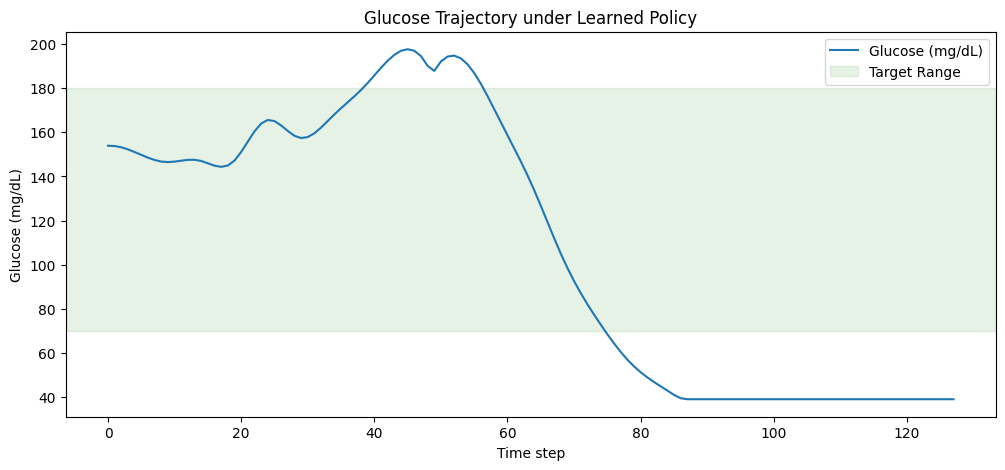

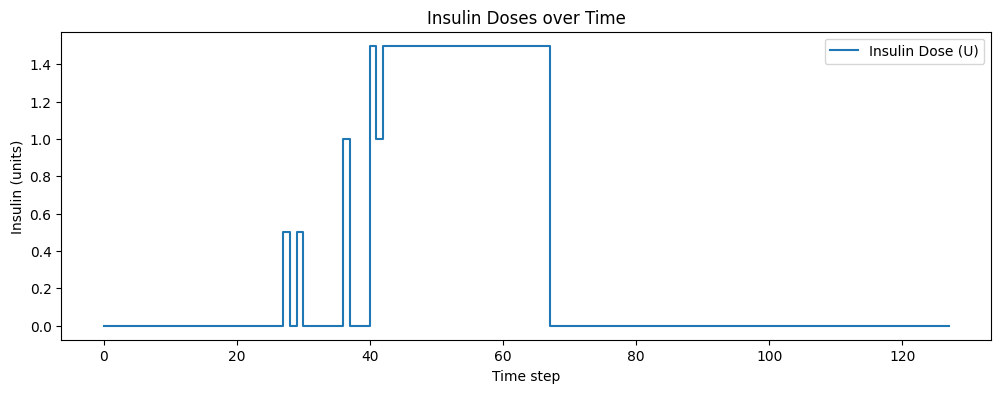

In [17]:
agent_test = TDControlAgent(n_states=n_states, n_actions=n_actions)
agent_test.Qvalues = np.load('reinforce_theta.npy')
# Set epsilon=0 for greedy policy (pure exploitation)
epsilon_eval = 0.1

# Start a new episode
obs = env.reset()

# # Access the scenario generator from the underlying environment
scenario_generator = env.env.scenario

print("Scenario of meals generated:")

# Access the 'meal' key from the scenario dictionary
print(scenario_generator.scenario['meal'])
if isinstance(obs, tuple):
    obs = obs[0]
if hasattr(obs, "CGM"):
    glucose = obs.CGM
elif isinstance(obs, dict) and 'CGM' in obs:
    glucose = obs['CGM']
elif isinstance(obs, (np.ndarray, list)):
    glucose = obs[0]
elif isinstance(obs, (float, int)):
    glucose = obs
else:
    raise ValueError(f"Unknown observation format: {type(obs)}")

glucose_velocity = 0
s = discretize_glucose(glucose, glucose_velocity)
a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
done = False

# Lists to record data
G_t = [glucose]
I_t = [action_space[a]]
rewards = []
times = [0]
t = 0

while not done and t < 500:
    insulin_dose = action_space[a]
    step_result = env.step(insulin_dose)
    if isinstance(step_result, tuple) and len(step_result) == 4:
        next_obs, _, done, info = step_result
    else:
        next_obs = step_result
        done = False

    if hasattr(next_obs, "CGM"):
        next_glucose = next_obs.CGM
    elif isinstance(next_obs, dict) and 'CGM' in next_obs:
        next_glucose = next_obs['CGM']
    elif isinstance(next_obs, (np.ndarray, list)):
        next_glucose = next_obs[0]
    elif isinstance(next_obs, (float, int)):
        next_glucose = next_obs
    else:
        raise ValueError(f"Unknown observation format: {type(next_obs)}")

    glucose_velocity = next_glucose - glucose
    new_s = discretize_glucose(next_glucose, glucose_velocity)
    r = reward_fn(next_glucose)
    rewards.append(r)
    G_t.append(next_glucose)
    I_t.append(insulin_dose)
    t += 1
    times.append(t)

    glucose = next_glucose
    s = new_s
    a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
    if next_glucose < 120:  # Safety rule
        a = 0  # Ensure no insulin is given if glucose is below 120

# Plot glucose over time
plt.figure(figsize=(12,5))
plt.plot(times, G_t, label='Glucose (mg/dL)')
plt.axhspan(70, 180, color='green', alpha=0.1, label='Target Range')
plt.xlabel('Time step')
plt.ylabel('Glucose (mg/dL)')
plt.title('Glucose Trajectory under Learned Policy')
plt.legend()
plt.show()

# Optional: Plot insulin doses
plt.figure(figsize=(12,4))
plt.step(times, I_t, label='Insulin Dose (U)', where='post')
plt.xlabel('Time step')
plt.ylabel('Insulin (units)')
plt.title('Insulin Doses over Time')
plt.legend()
plt.show()

## PID Controller

The controller's action ($u(t)$) is calculated by summing three components based on the "error" ($e(t)$), which is the difference between the desired value and the current value.

* PID Controller Formula

$$u(t) = K_p e(t) + K_i \int_{0}^{t} e(\tau) d\tau + K_d \frac{de(t)}{dt}$$

* Brief Explanation of Each Term:

    * **Proportional Term (P):** $K_p * e(t)$
        * It reacts to the **present** error. If the error is large now, the action is large. It provides the main, immediate response.

    * **Integral Term (I):** $K_i * \int_{0}^{t} e(\tau) d\tau$
        * It corrects the error accumulated in the **past**. This term eliminates small, persistent deviations over time.

    * **Derivative Term (D):** $K_d * \frac{de(t)}{dt}$
        * It anticipates **future** error based on its rate of change. If the error is decreasing rapidly, this term acts as a "brake" to prevent overshooting the target.

In summary, the controller combines a reaction to the **present (P)**, a correction for the **past (I)**, and a prediction of the **future (D)** to achieve stable and precise control.

In [18]:
class PIDController:
    """
    A Proportional-Integral-Derivative (PID) controller designed to work with
    a discrete action space, making it comparable to a Reinforcement Learning agent.
    """
    def __init__(self, Kp, Ki, Kd, target_glucose=115.0, sample_time=1, max_insulin=2., min_insulin=0.0):
        """
        Initializes the PID controller's parameters.

        Args:
            Kp (float): The Proportional gain.
            Ki (float): The Integral gain.
            Kd (float): The Derivative gain.
            target_glucose (float): The desired glucose level setpoint.
            sample_time (int): The time in minutes between each controller step.
            max_insulin (float): The maximum allowed insulin dose.
            min_insulin (float): The minimum allowed insulin dose.
        """
        # --- Controller Gains ---
        self.Kp, self.Ki, self.Kd = Kp, Ki, Kd
        
        # --- Controller Setpoints and Limits ---
        self.target_glucose = target_glucose
        self.sample_time = sample_time
        self.max_insulin, self.min_insulin = max_insulin, min_insulin
        
        # --- Controller State Variables ---
        self.integral_error = 0.0 # Accumulates past errors
        self.last_error = 0.0     # The error from the previous time step
        self.last_output = 0.0    # The last calculated continuous output (for anti-windup)

    def compute(self, current_glucose, action_space):
        """
        Calculates the ideal insulin dose based on the current glucose,
        and then discretizes the output to match the RL agent's action space.

        Args:
            current_glucose (float): The continuous glucose reading from the environment.
            action_space (np.array): The array of possible discrete actions (e.g., [0.0, 0.5, 1.0]).

        Returns:
            float: The chosen discrete insulin dose.
        """
        # 1. The PID uses the CONTINUOUS GLUCOSE value to calculate the error.
        #    This is essential for the formula to work correctly.
        error = current_glucose - self.target_glucose

        # 2. Calculate the ideal continuous dose by summing the P, I, and D terms.
        
        # Proportional Term: Reacts to the current error.
        p_term = self.Kp * error
        
        # Integral Term: Corrects for past, accumulated errors.
        # Includes an "anti-windup" check: only accumulate error if the pump is not saturated.
        if self.min_insulin < self.last_output < self.max_insulin:
            self.integral_error += error * self.sample_time
        i_term = self.Ki * self.integral_error
        
        # Derivative Term: Anticipates future error based on the rate of change.
        derivative_error = (error - self.last_error) / self.sample_time
        d_term = self.Kd * derivative_error
        
        # Sum the terms to get the ideal continuous output.
        continuous_output = p_term + i_term + d_term
        
        # Clamp the output to the pump's physical limits.
        continuous_output = max(self.min_insulin, min(self.max_insulin, continuous_output))
        
        # 3. DISCRETIZE THE OUTPUT to make it comparable to the RL agent.
        #    Find the index of the action in the action_space that is closest to our ideal continuous dose.
        closest_action_index = np.argmin(np.abs(action_space - continuous_output))
        # Select that discrete dose from the action space.
        discrete_output = action_space[closest_action_index]

        # 4. Update the controller's state for the next iteration.
        self.last_error = error
        self.last_output = continuous_output # Save the continuous output for the anti-windup logic
        
        return discrete_output

    def reset(self):
        """
        Resets the internal state of the controller.
        This should be called at the beginning of each new simulation episode.
        """
        self.integral_error = 0.0
        self.last_error = 0.0
        self.last_output = 0.0

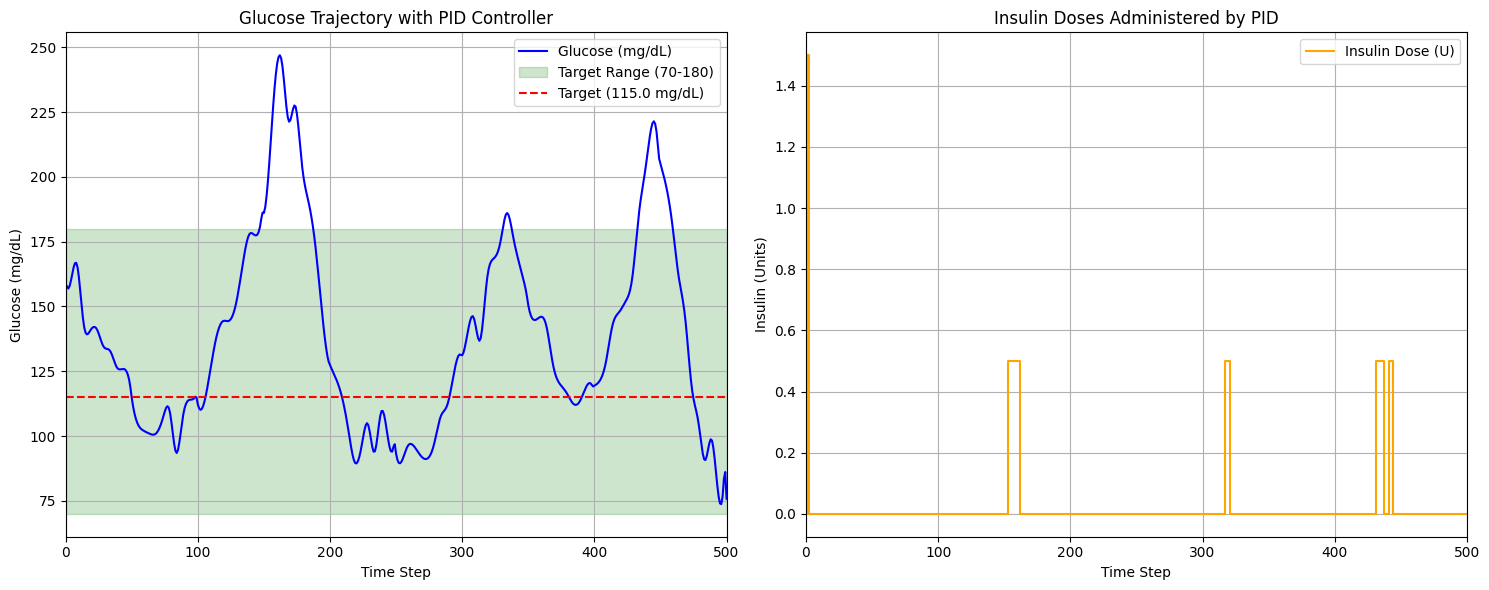

In [19]:
# --- 1. Initialization ---
action_space = np.arange(0, 2., 0.5)
kp_gain = 0.0007   
ki_gain = 0.000001 
kd_gain = 0.05     

# Ensure the PIDController class is defined in a cell above this one
pid_controller = PIDController(Kp=kp_gain, Ki=ki_gain, Kd=kd_gain, target_glucose=115.0)
env_test = T1DSimEnv()
obs = env_test.reset()
pid_controller.reset()

# --- Initial Glucose Logic ---

if isinstance(obs, tuple):
    obs = obs[0]
glucose = obs.CGM if hasattr(obs, "CGM") else obs

# --- 2. Simulation Loop  ---

times = [0]
glucose_history = [glucose]
insulin_history = [0] 

for t in range(500):
    # Compute the discrete insulin dose
    insulin_dose = pid_controller.compute(glucose, action_space)
    
    # Take a step in the environment
    try:
        step_result, _, done, _ = env_test.step(insulin_dose)
        next_glucose = step_result.CGM if hasattr(step_result, "CGM") else step_result
    except Exception as e:
        print(f"Simulation stopped due to an error at step {t+1}: {e}")
        break

    if next_glucose < 120:  # Safety rule
        insulin_dose = 0  # Ensure no insulin is given if glucose is below 120

    # Record data for this step
    times.append(t + 1) 
    glucose_history.append(next_glucose)
    insulin_history.append(insulin_dose)
    
    # Update glucose for the next iteration
    glucose = next_glucose
    
    # If the environment signals 'done', we exit the loop immediately.
    # No more data filling.
    if done:
        
        break 


plt.figure(figsize=(15, 6))

# Glucose Plot
plt.subplot(1, 2, 1)
plt.plot(times, glucose_history, label='Glucose (mg/dL)', color='blue')
plt.axhspan(70, 180, color='green', alpha=0.2, label='Target Range (70-180)')
plt.axhline(pid_controller.target_glucose, color='red', linestyle='--', label=f'Target ({pid_controller.target_glucose} mg/dL)')
plt.xlabel('Time Step') 
plt.ylabel('Glucose (mg/dL)')
plt.title('Glucose Trajectory with PID Controller')
plt.legend()
plt.grid(True)
plt.xlim(0, 500)
# Insulin Plot
plt.subplot(1, 2, 2)
# We use times[:-1] and insulin_history[:-1] to match the lengths for a step plot
plt.step(times[:-1], insulin_history[:-1], label='Insulin Dose (U)', where='post', color='orange')
plt.xlabel('Time Step') 
plt.ylabel('Insulin (Units)')
plt.title('Insulin Doses Administered by PID')
plt.legend()
plt.grid(True)
plt.xlim(0, 500)
plt.tight_layout()
plt.show()

In [20]:
def evaluate_pid(env, meals_scenario, action_space, pid_controller, max_steps=500):
    obs = env.reset()
    env.env.scenario.scenario['meal'] = meals_scenario  # Enforce same meals
    pid_controller.reset()
    if isinstance(obs, tuple):
        obs = obs[0]
    glucose = obs.CGM if hasattr(obs, "CGM") else obs

    times = [0]
    glucose_history = [glucose]
    insulin_history = [0]
    done = False

    for t in range(max_steps):
        insulin_dose = pid_controller.compute(glucose, action_space)
        try:
            step_result, _, done, _ = env.step(insulin_dose)
            next_glucose = step_result.CGM if hasattr(step_result, "CGM") else step_result
        except Exception as e:
            print(f"Simulation stopped due to an error at step {t+1}: {e}")
            break

        if next_glucose < 120:
            insulin_dose = 0

        times.append(t + 1)
        glucose_history.append(next_glucose)
        insulin_history.append(insulin_dose)
        glucose = next_glucose
        if done:
            break

    return times, glucose_history, insulin_history

In [21]:
def evaluate_agent(agent, Q_table, env, meals_scenario, action_space, discretize_glucose, reward_fn, epsilon_eval=0.1, max_steps=500):
    agent.Qvalues = Q_table
    obs = env.reset()
    env.env.scenario.scenario['meal'] = meals_scenario  # enforce same meal scenario

    # Extract glucose value from observation
    if isinstance(obs, tuple):
        obs = obs[0]
    if hasattr(obs, "CGM"):
        glucose = obs.CGM
    elif isinstance(obs, dict) and 'CGM' in obs:
        glucose = obs['CGM']
    elif isinstance(obs, (np.ndarray, list)):
        glucose = obs[0]
    elif isinstance(obs, (float, int)):
        glucose = obs
    else:
        raise ValueError(f"Unknown observation format: {type(obs)}")
    
    glucose_velocity = 0
    s = discretize_glucose(glucose, glucose_velocity)
    a = agent.get_action_epsilon_greedy(s, epsilon_eval)
    done = False

    G_t = [glucose]
    I_t = [action_space[a]]
    rewards = []
    times = [0]
    t = 0

    while not done and t < max_steps:
        insulin_dose = action_space[a]
        step_result = env.step(insulin_dose)
        if isinstance(step_result, tuple) and len(step_result) == 4:
            next_obs, _, done, info = step_result
        else:
            next_obs = step_result
            done = False

        # Extract glucose from next_obs
        if hasattr(next_obs, "CGM"):
            next_glucose = next_obs.CGM
        elif isinstance(next_obs, dict) and 'CGM' in next_obs:
            next_glucose = next_obs['CGM']
        elif isinstance(next_obs, (np.ndarray, list)):
            next_glucose = next_obs[0]
        elif isinstance(next_obs, (float, int)):
            next_glucose = next_obs
        else:
            raise ValueError(f"Unknown observation format: {type(next_obs)}")

        glucose_velocity = next_glucose - glucose
        new_s = discretize_glucose(next_glucose, glucose_velocity)
        r = reward_fn(next_glucose)
        rewards.append(r)
        G_t.append(next_glucose)
        I_t.append(insulin_dose)
        t += 1
        times.append(t)

        glucose = next_glucose
        s = new_s
        a = agent.get_action_epsilon_greedy(s, epsilon_eval)
        if next_glucose < 120:  # Safety rule: no insulin if glucose < 120
            a = 0

    return times, G_t, I_t, rewards

Meal scenario: {'time': [np.float64(447.0), np.float64(651.0), np.float64(898.0), np.float64(1100.0), np.float64(1310.0)], 'amount': [42, 68, 4, 59, 12]}


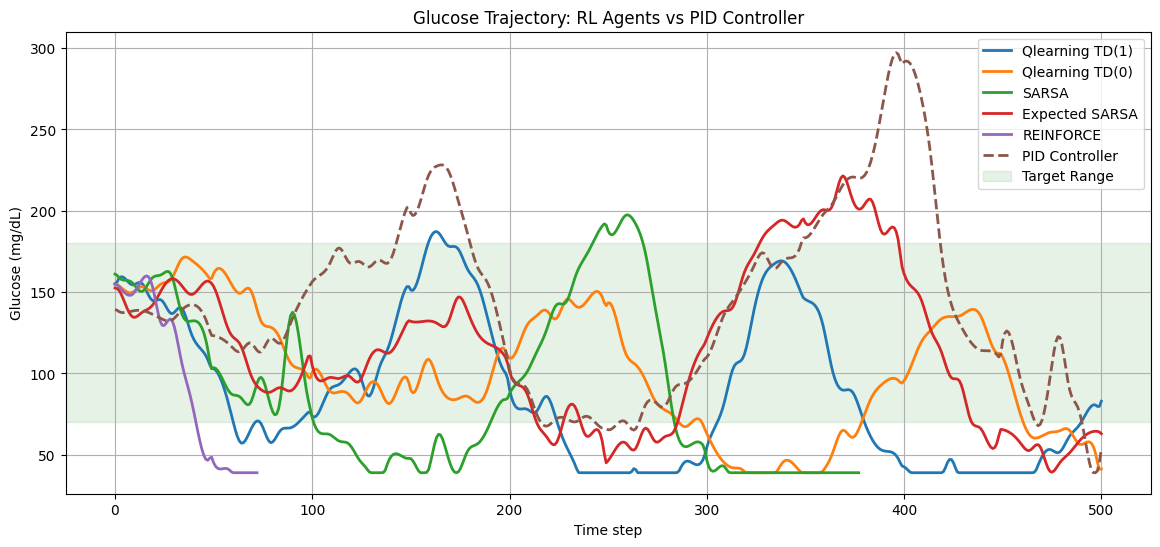

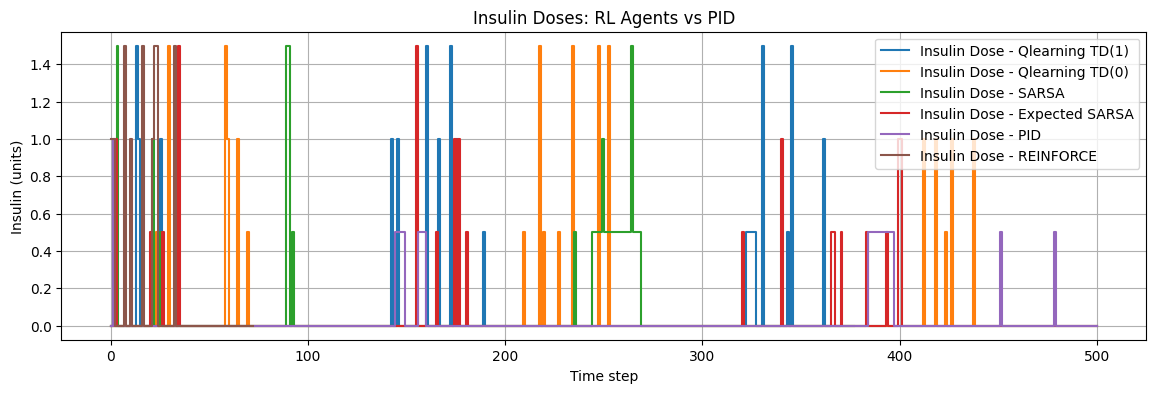

In [22]:
action_space = np.arange(0, 2., 0.5)
kp_gain = 0.0007   
ki_gain = 0.000001 
kd_gain = 0.05    

# Ensure you have these classes and functions defined:
# - TDControlAgent, T1DSimEnv, PIDController, discretize_glucose, reward_fn

# Create agents and environment
Q1 = np.load('q1_table.npy')
Q2 = np.load('q_table.npy')
Q3 = np.load('s_table.npy')
Q4 = np.load('e_table.npy')
Q5 = np.load('reinforce_theta.npy')
agent1 = TDControlAgent(n_states=n_states, n_actions=n_actions)
agent2 = TDControlAgent(n_states=n_states, n_actions=n_actions)
agent3 = TDControlAgent(n_states=n_states, n_actions=n_actions)
agent4 = TDControlAgent(n_states=n_states, n_actions=n_actions)
agent5 = TDControlAgent(n_states=n_states, n_actions=n_actions)
pid_controller = PIDController(Kp=kp_gain, Ki=ki_gain, Kd=kd_gain, target_glucose=115.0)

env = T1DSimEnv()
obs = env.reset()
scenario_generator = env.env.scenario
meals_scenario = scenario_generator.scenario['meal']
print("Meal scenario:", meals_scenario)

# --- 4. Run Evaluations ---

# RL Agent 1
env_agent1 = T1DSimEnv()
times1, G_t1, I_t1, rewards1 = evaluate_agent(agent1, Q1, env_agent1, meals_scenario, action_space, discretize_glucose, reward_fn)
# RL Agent 2
env_agent2 = T1DSimEnv()
times2, G_t2, I_t2, rewards2 = evaluate_agent(agent2, Q2, env_agent2, meals_scenario, action_space, discretize_glucose, reward_fn)
# RL Agent 3 (SARSA)
env_agent3 = T1DSimEnv()
times3, G_t3, I_t3, rewards3 = evaluate_agent(agent3, Q3, env_agent3, meals_scenario, action_space, discretize_glucose, reward_fn)
# RL Agent 4 (Expected SARSA)
env_agent4 = T1DSimEnv()
times4, G_t4, I_t4, rewards4 = evaluate_agent(agent4, Q4, env_agent4, meals_scenario, action_space, discretize_glucose, reward_fn)
# PID Controller
env_pid = T1DSimEnv()
times_pid, G_pid, I_pid = evaluate_pid(env_pid, meals_scenario, action_space, pid_controller)
# Reinforce
env_reinforce = T1DSimEnv()
times5, G_t5, I_t5, rewards5 =evaluate_agent(agent5, Q5, env_reinforce, meals_scenario, action_space, discretize_glucose, reward_fn)

# --- 5. Plotting ---

plt.figure(figsize=(14,6))
plt.plot(times1, G_t1, label='Qlearning TD(1)', linewidth=2)
plt.plot(times2, G_t2, label='Qlearning TD(0)', linewidth=2)
plt.plot(times3, G_t3, label='SARSA', linewidth=2)
plt.plot(times4, G_t4, label='Expected SARSA', linewidth=2)
plt.plot(times5, G_t5, label='REINFORCE', linewidth=2)
plt.plot(times_pid, G_pid, label='PID Controller', linestyle='--', linewidth=2)
plt.axhspan(70, 180, color='green', alpha=0.1, label='Target Range')
plt.xlabel('Time step')
plt.ylabel('Glucose (mg/dL)')
plt.title('Glucose Trajectory: RL Agents vs PID Controller')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,4))
plt.step(times1, I_t1, label='Insulin Dose - Qlearning TD(1)', where='post')
plt.step(times2, I_t2, label='Insulin Dose - Qlearning TD(0)', where='post')
plt.step(times3, I_t3, label='Insulin Dose - SARSA', where='post')
plt.step(times4, I_t4, label='Insulin Dose - Expected SARSA', where='post')
plt.step(times_pid, I_pid, label='Insulin Dose - PID', where='post')
plt.step(times5, I_t5, label='Insulin Dose - REINFORCE', where='post')
plt.xlabel('Time step')
plt.ylabel('Insulin (units)')
plt.title('Insulin Doses: RL Agents vs PID')
plt.legend()
plt.grid(True)
plt.show()

## Conclusions

Following a detailed analysis of all systems, it is important to highlight that, in general, all the agents and the controller we have evaluated are very good and demonstrate a high degree of competence for the task of glucose regulation. The Reinforcement Learning (RL) agents, in particular, show an impressive learning capability, managing to keep glucose levels within the target range with remarkable precision and for long periods of time. Their ability to adapt and react dynamically is, without a doubt, technologically superior. However, after re-analyzing these results, we have adopted a different and more clinically relevant evaluation criterion: **patient safety is the highest priority, and hypoglycemia (low glucose levels) represents an acute and much more severe danger than hyperglycemia (high glucose levels).** From this perspective, our conclusions are:

* **PID Controller (Purple Line):** While we observe that the PID controller allows glucose to rise to hyperglycemic levels, the most important finding is that it **never causes a dangerous hypoglycemic episode**. Its glucose troughs always remain within a safe range, well above critical levels. Its behavior, while less precise at staying within the target range, proves to be a conservative and safe-by-default strategy that prioritizes avoiding fatal drops.

* **Reinforcement Learning (RL) Agents:** In contrast, all the RL agents we have developed exhibit high-risk behavior. The **Q-learning and SARSA algorithms (blue, orange, and green lines)** are particularly dangerous, as on multiple occasions (for example, around time steps 75-125) they cause glucose to plummet to critically low levels, which is unacceptable. Even the **Expected SARSA** agent (red line), which appeared more stable, constantly flirts with the lower limit, demonstrating an aggressiveness that leaves no margin for error and endangers the patient.

The dosing strategy of each controller confirms this risk analysis:

* **PID Controller (Purple Line):** Its method of applying moderate and spaced-out doses is, in fact, a **safety feature**. By not aggressively injecting large amounts of insulin, it prevents the primary cause of iatrogenic (treatment-induced) hypoglycemia. Its apparent "passivity" is a mechanism that ensures the system is not overloaded.

* **RL Agents:** The dosing strategies of the RL agents reveal their recklessness. **Q-learning's** "all-or-nothing" tactic of applying maximum doses is the direct cause of the dangerous glucose drops. The active and variable dosing of **SARSA and Expected SARSA**, while seemingly more intelligent, is actually a high-risk strategy that depends on perfect precision. A minor miscalculation in their aggressive dosing policy can have severe consequences.


Considering that avoiding hypoglycemia is the most important factor for patient safety, **we conclude that the PID controller is the superior and more responsible option.**

Although it doesn't keep glucose perfectly within the target range, its predictable and conservative strategy ensures the patient is never exposed to an acute risk of hypoglycemia. The RL agents, on the other hand, despite their sophistication, introduce an unacceptable level of danger. In a real-world clinical setting, it is preferable to manage **controllable hyperglycemia** than to risk a potentially **fatal hypoglycemic event**.